## Inference testing for Tacotron2 with FaceStyle Module as GST replacement

In [86]:
from pathlib import Path
import IPython
import torch
import numpy as np
from random import shuffle
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
from models.inception_resnet_v1 import InceptionResnetV1 as TrainedInception
from models.facenet import FaceNet
from torchvision import transforms
from models.mtcnn import fixed_image_standardization
from PIL import Image
from tqdm import tqdm
import matplotlib.colors as mcolors

In [60]:
base_face_model = TrainedInception(pretrained="casia-webface", num_classes=5089).eval().cuda()
base_face = TrainedInception(pretrained="casia-webface", num_classes=5089)

facenet_finetuned = "../results/facenet/spring-glitter-9/facestyle-epoch=14-val_loss=0.07.ckpt"
if facenet_finetuned is not None:
    face_model = FaceNet.load_from_checkpoint(facenet_finetuned, model=base_face)
_ = face_model.eval()
_ = face_model.cuda()

In [112]:
baseline_facenet = InceptionResnetV1(pretrained="casia-webface")
_ = baseline_facenet.eval()
_ = baseline_facenet.cuda()

In [113]:
total = 100
per_spk = 30
paths = []
wav_paths = []
images_path = Path("../data/images/val")
spks = list(images_path.glob("*"))
spk_count = []
for spk in spks:
    spk_count.append((spk, len(list(spk.glob("*")))))
spk_count = sorted(spk_count, key=lambda x: x[1], reverse=True)[:total*2]
spks = [x for x, y in spk_count]
shuffle(spks)
for speaker in spks[:total]:
    new_paths = list(speaker.glob("*.jpg"))[:per_spk]
    #wavs = map(lambda x: audio_path / speaker.stem / (x.stem.split("_")[0]+ "_" + str(int(x.stem.split("_")[1])-1) + ".wav"), new_paths)
    #wavs = map(lambda x: audio_path / speaker.stem / (x.stem.split("_")[0]+ ".wav"), new_paths)

    paths += new_paths
    #wav_paths += wavs
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, paths))

In [114]:
image_transform = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

In [115]:
baseline_embs = np.zeros((len(paths), 512), dtype=np.float64)
trained_embs = np.zeros((len(paths), 512), dtype=np.float64)
with torch.no_grad():
    for i, path in enumerate(tqdm(paths)):
        img = Image.open(path)
        img = image_transform(img).cuda()
        baseline_embs[i] = base_face_model.forward(img.unsqueeze(0)).squeeze(0).cpu().numpy() 
        trained_embs[i] = face_model.forward(img.unsqueeze(0)).squeeze(0).cpu().numpy() 

        


100%|██████████| 2874/2874 [01:23<00:00, 34.27it/s]


In [116]:
cs = list(mcolors.CSS4_COLORS.values())
def to_int_rgb(hex_rgb):
    r,g,b = hex_rgb[1:3], hex_rgb[3:5], hex_rgb[5:7]
    return int(r, 16), int(g, 16), int(b, 16)
dark_colors = [x for x in cs if sum(to_int_rgb(x)) < 600]

In [125]:
def plot_tsne(voice_embs, face_embs, speakers, **kwargs):
    """colors = np.array([
        [0, 127, 70],
        [255, 0, 0],
        [255, 217, 38],
        [0, 135, 255],
        [165, 0, 165],
        [255, 167, 255],
        [97, 142, 151],
        [0, 255, 255],
        [255, 96, 38],
        [142, 76, 0],
        [33, 0, 127],
        [0, 0, 0],
        [183, 183, 183],
        [76, 255, 0],
    ], dtype=float) / 255 """
    colors = dark_colors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
    # Compute the 2D projections. You could also project to another number of dimensions (e.g. 
    # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
    reducer = UMAP(**kwargs) #TSNE(perplexity=50, learning_rate=400)
    all_embs = np.concatenate([voice_embs, face_embs], axis=0)
    projs = reducer.fit_transform(all_embs)
    projs, projs2 = projs[:len(voice_embs)], projs[len(voice_embs):]
    #reducer = reducer.fit(voice_embs)
    #projs = reducer.transform(voice_embs)
    #projs2 = reducer.fit_transform(face_embs)
    ax1.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax2.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    # Draw the projections
    speakers = np.array(speakers)
    #colors = colors or _my_colors
    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        speaker_projs2 = projs2[speakers == speaker]

        marker = "o"
        label = f"Speaker {i+1}"
        ax1.scatter(*speaker_projs.T, c=[colors[i]])#, marker=marker, label=label)
        ax2.scatter(*speaker_projs2.T, c=[colors[i]])#, marker=marker)


    #ax1.set_aspect('tight')
    #ax2.set_aspect('tight')
    plt.tight_layout()
    fig.legend(loc='lower left', fontsize="large")
    ax1.set_title("Baseline Facenet", fontsize="xx-large")
    ax2.set_title("Finetuned Facenet", fontsize="xx-large")
    

/home/bjorn/anaconda3/envs/facevoice_training/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
No handles with labels found to put in legend.


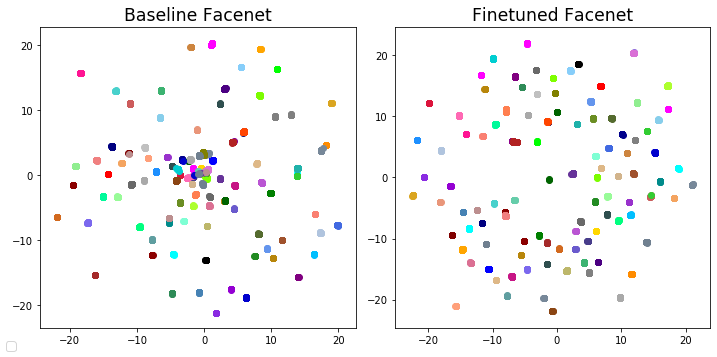

In [126]:
_ = plot_tsne(baseline_embs, trained_embs, speakers)
plt.tight_layout()
plt.savefig("./plots/baseline_vs_finetuned_facenet3.pdf")
plt.show()

In [96]:
#_ = plot_projections(voice_embs, speakers, title="Embedding projections of baseline facenet", n_components=2)

In [18]:
def plot_one(all_embs, speakers, **kwargs):
    colors = np.array([
        [0, 127, 70],
        [255, 0, 0],
        [255, 217, 38],
        [0, 135, 255],
        [165, 0, 165],
        [255, 167, 255],
        [97, 142, 151],
        [0, 255, 255],
        [255, 96, 38],
        [142, 76, 0],
        [33, 0, 127],
        [0, 0, 0],
        [183, 183, 183],
        [76, 255, 0],
    ], dtype=float) / 255 
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_axes([0,0,1,1])# , projection="3d")
        
    # Compute the 2D projections. You could also project to another number of dimensions (e.g. 
    # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
    reducer = UMAP(**kwargs) #TSNE(perplexity=50, learning_rate=400)
    projs = reducer.fit_transform(all_embs)

    #projs = reducer.fit_transform(embeds1)
    #projs2 = reducer.fit_transform(embeds2)
    
    # Draw the projections
    speakers = np.array(speakers)
    #colors = colors or _my_colors
    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]

        marker = "o"
        label = speaker[:5]
        ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)
    

    
    ax.legend(title="Speakers", ncol=2)
    #ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])